In [1]:
from scipy.linalg import expm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie danych
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Redukcja biasu
bias_redX = test_data['GyroX'][:100].mean()
bias_redY = test_data['GyroY'][:100].mean()
bias_redZ = test_data['GyroZ'][:100].mean()

test_data['GyroX'] -= bias_redX
test_data['GyroY'] -= bias_redY
test_data['GyroZ'] -= bias_redZ * 0.915

test_data['GyroX'] /= 1000
test_data['GyroY'] /= 1000
test_data['GyroZ'] /= 1000

# Funkcje pomocnicze
def calculate_skew_symmetric_matrix(gyro):
    wx, wy, wz = gyro
    return np.array([
        [0, -wz, wy],
        [wz, 0, -wx],
        [-wy, wx, 0]
    ])

def calculate_angles_from_rotation_matrix(R):
    phi = np.arctan2(R[2, 1], R[2, 2])  # Roll
    theta = -np.arcsin(R[2, 0])         # Pitch
    psi = np.arctan2(R[1, 0], R[0, 0])  # Yaw
    return np.degrees(phi), np.degrees(theta), np.degrees(psi)

def calculate_angles_from_accelerometer(acc):
    ax, ay, az = acc
    roll = np.arctan2(ay, az)  # Roll
    pitch = np.arctan2(-ax, np.sqrt(ay**2 + az**2))  # Pitch
    return np.degrees(roll), np.degrees(pitch)

# Funkcja główna
def kalman_filter(data):
    """
    Filtr Kalmana zgodnie z przedstawionym schematem, bez korekcji yaw.
    """
    n = len(data)
    roll_est = np.zeros(n)
    pitch_est = np.zeros(n)
    yaw_est = np.zeros(n)

    # Inicjalizacja
    x_k = np.array([0, 0])  # Początkowy stan (roll, pitch)
    P_k = np.eye(2)         # Początkowa macierz kowariancji
    Q = np.diag([0.01, 0.01])  # Szum procesu
    R_acc = np.diag([1, 1])      # Szum pomiarowy akcelerometru
    A = np.eye(2)                # Model dynamiki systemu
    H = np.eye(2)                # Macierz obserwacji

    dt = data['Time'].diff().fillna(method='bfill').to_numpy()
    deg_to_rad = np.pi / 180

    # Yaw - integracja bez korekcji
    yaw = 0  # Początkowy kąt yaw

    for t in range(n):  # Poprawka: uwzględnij wszystkie wiersze, w tym ostatni
        # Dane żyroskopu
        gyro = np.array([
            data['GyroX'][t] * deg_to_rad,
            data['GyroY'][t] * deg_to_rad,
            data['GyroZ'][t] * deg_to_rad
        ])

        # Dane akcelerometru
        acc = np.array([data['AccX'][t], data['AccY'][t], data['AccZ'][t]])

        # Wyliczenie przyrostów z żyroskopu (tylko roll i pitch)
        roll_gyro = x_k[0] + gyro[0] * dt[t]
        pitch_gyro = x_k[1] + gyro[1] * dt[t]
        x_pred = np.array([roll_gyro, pitch_gyro])

        # Aktualizacja macierzy kowariancji predykcji
        P_pred = A @ P_k @ A.T + Q

        # Obliczanie kątów z akcelerometru
        roll_acc, pitch_acc = calculate_angles_from_accelerometer(acc)
        z = np.array([roll_acc, pitch_acc])

        # Korekcja dla roll i pitch
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R_acc)
        x_corr = x_pred + K @ (z - H @ x_pred)
        P_k = (np.eye(2) - K @ H) @ P_pred

        # Zapis wyników
        roll_est[t], pitch_est[t] = x_corr

        # Yaw - tylko integracja
        yaw += gyro[2] * dt[t]  # Aktualizacja yaw przez całkowanie
        yaw_est[t] = np.degrees(yaw)  # Konwersja na stopnie

        # Aktualizacja stanu
        x_k = x_corr

    return roll_est, pitch_est, yaw_est

# Całkowanie z filtrem Kalmana
test_roll, test_pitch, test_yaw = kalman_filter(test_data)

# Dodanie wyników do danych testowych
test_data['roll_pred'] = test_roll
test_data['pitch_pred'] = test_pitch
test_data['yaw_pred'] = test_yaw


C:\Users\konra\AppData\Local\Temp\ipykernel_4696\610314717.py:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = data['Time'].diff().fillna(method='bfill').to_numpy()


In [2]:
# Obliczanie różnicy (bias)
roll_bias = train_data['roll'][:7000].mean() - test_data['roll_pred'][:7000].mean()
pitch_bias = train_data['pitch'][:7000].mean() - test_data['pitch_pred'][:7000].mean()
yaw_bias = train_data['yaw'][:7000].mean() - test_data['yaw_pred'][:7000].mean()

# Dodawanie różnicy do każdego wyniku
test_data['roll_pred'] += roll_bias
test_data['pitch_pred'] += pitch_bias
test_data['yaw_pred'] += yaw_bias

print(f"Roll bias: {roll_bias}")
print(f"Pitch bias {pitch_bias}")
print(f"Yaw bias {yaw_bias}")

Roll bias: 2.967781990551609
Pitch bias 0.1218703068941331
Yaw bias 0.16166760154960613


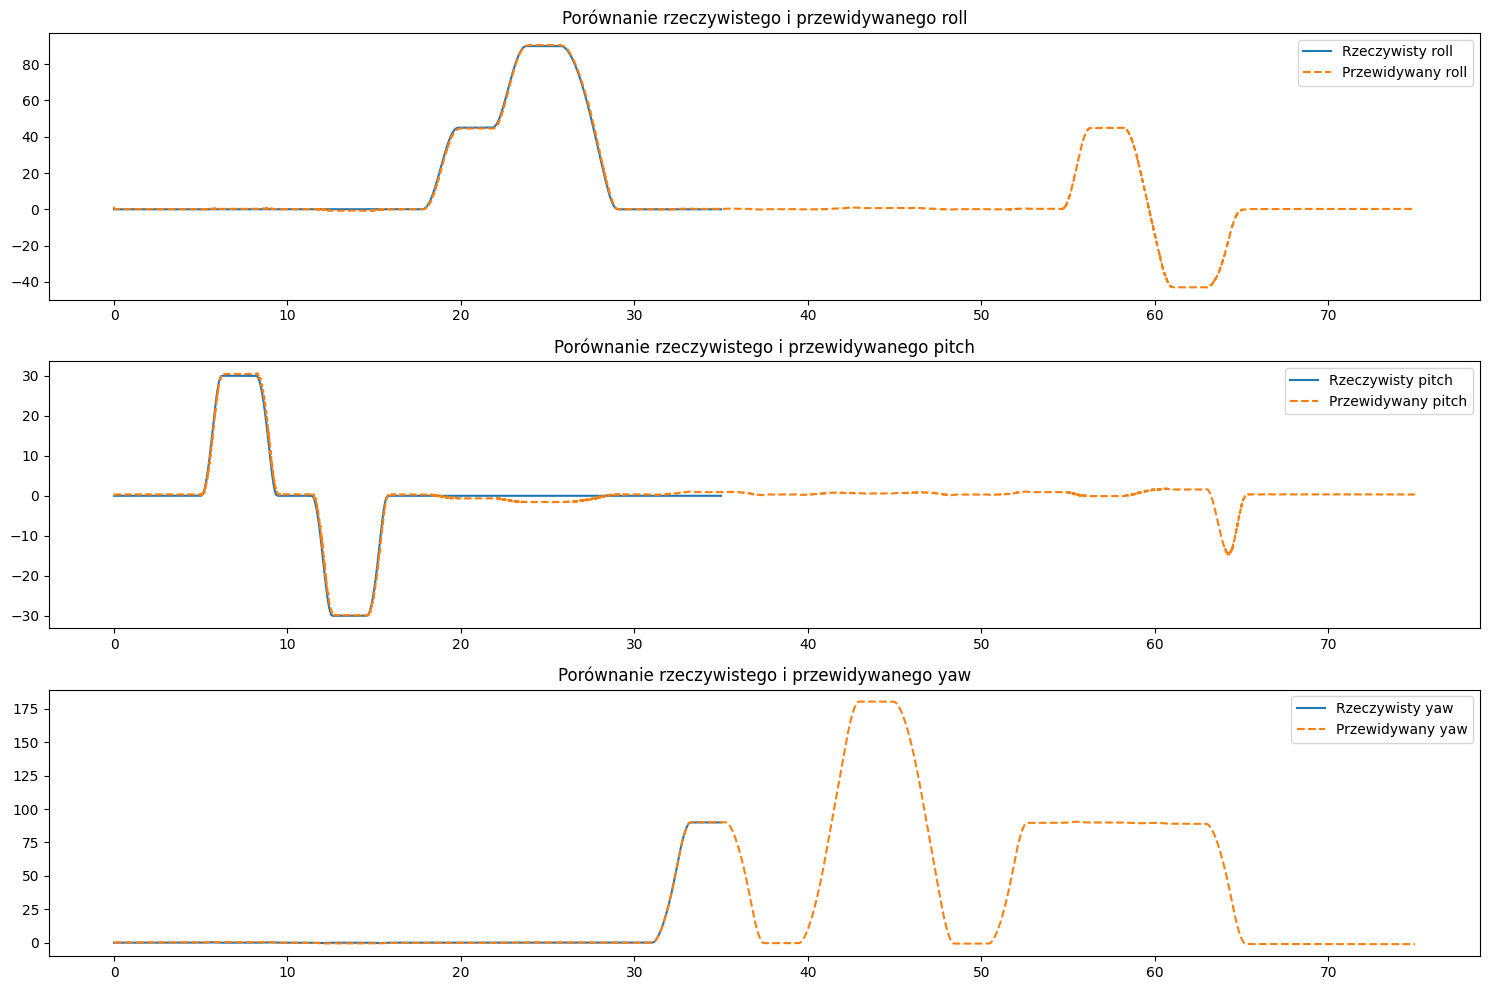

In [3]:
# Wizualizacja wyników
plt.figure(figsize=(15, 10))

# Roll
plt.subplot(3, 1, 1)
plt.plot(train_data['Time'], train_data['roll'], label='Rzeczywisty roll')
plt.plot(test_data['Time'], test_data['roll_pred'], label='Przewidywany roll', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego roll')

# Pitch
plt.subplot(3, 1, 2)
plt.plot(train_data['Time'], train_data['pitch'], label='Rzeczywisty pitch')
plt.plot(test_data['Time'], test_data['pitch_pred'], label='Przewidywany pitch', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego pitch')

# Yaw
plt.subplot(3, 1, 3)
plt.plot(train_data['Time'], train_data['yaw'], label='Rzeczywisty yaw')
plt.plot(test_data['Time'], test_data['yaw_pred'], label='Przewidywany yaw', linestyle='--')
plt.legend()
plt.title('Porównanie rzeczywistego i przewidywanego yaw')

plt.tight_layout()
plt.show()


In [ ]:
submission = pd.DataFrame({
    'Id': test_data.index + 1,
    'pitch': test_data['pitch_pred'],
    'roll': test_data['roll_pred'],
    'yaw': test_data['yaw_pred']
})

submission.to_csv('results/sample-submission.csv', index=False)
print("Wyniki zapisano do pliku 'sample-submission.csv'")

Wyniki zapisano do pliku 'sample-submission.csv'
